# Startup Delay Classification from Encrypted Network Traffic

In this notebook, we address the problem of **startup delay failure detection**, i.e., predicting whether a video session successfully starts playback or times out.

Rather than predicting the exact startup delay (a regression task handled separately), this notebook focuses on a **binary classification task**:
- **Started**: the video begins playback before the timeout threshold
- **Timeout**: playback never starts due to adverse network conditions

This task is operationally relevant for network operators, as startup failures correspond to a severe Quality of Experience (QoE) degradation.


In [1]:
import os
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance


# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

BASE_PATH = "/content/drive/MyDrive/ML Project data/material"

COLUMNS_PATH = os.path.join(BASE_PATH, "column-names.txt")
DATA_PATH = os.path.join(BASE_PATH, "dataset.csv")

print("Columns file:", COLUMNS_PATH)
print("Data file:", DATA_PATH)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Columns file: /content/drive/MyDrive/ML Project data/material/column-names.txt
Data file: /content/drive/MyDrive/ML Project data/material/dataset.csv


This function is due to the fact that our dataset doesn't have the column names so I parse the column-names.txt file to then add them to the dataset

In [3]:
def parse_column_names(path):
    names = []
    with open(path, "r") as f:
        for line in f:
            line = line.strip("\n")

            # SQL-style ascii table
            if line.startswith("|"):
                parts = [x.strip() for x in line.split("|")]
                if (
                    len(parts) >= 2
                    and parts[1] not in ("Field", "Type", "Null", "Key", "Default", "Extra", "")
                ):
                    names.append(parts[1])

            # Plain list format
            elif line and not line.startswith("+") and not line.startswith("-"):
                token = line.strip()
                if token and all(c.isalnum() or c == "_" for c in token):
                    names.append(token)

    # Remove duplicates while preserving order
    seen, unique = set(), []
    for n in names:
        if n not in seen:
            unique.append(n)
            seen.add(n)

    return unique

In [4]:
col_names = parse_column_names(COLUMNS_PATH)

print(f"Found {len(col_names)} column names.")
print(col_names[:20])

Found 270 column names.
['videoID', 'category', 'bitrates_144p', 'bitrates_240p', 'bitrates_360p', 'bitrates_480p', 'bitrates_720p', 'bitrates_1080p', 'join_time', 'stallingNumber', 'totalStallDuration', 'outbandQoS_DL_TP', 'outbandQoS_UL_TP', 'outbandQoS_RTT', 'outbandQoS_RTT_STD', 'outbandQoS_LOSS', 'pcapStats_stats_avg_DL_TP', 'pcapStats_stats_avg_UL_t', 'pcapStats_stats_avg_DL_t', 'pcapStats_stats_avg_DL_pkt']


In [5]:
# Clean column names by removing 'pcapStats_' prefix
col_names = [name.replace('pcapStats_', '').replace('pcapstats_', '') for name in col_names]
print(f"Cleaned {len(col_names)} column names (removed pcapStats/pcapstats prefix)")

Cleaned 270 column names (removed pcapStats/pcapstats prefix)


In [6]:
df = pd.read_csv(
    DATA_PATH,
    header=None,
    names=col_names,
    low_memory=False
)

print("Shape:", df.shape)
df.head(3)

Shape: (111919, 270)


,videoID,category,bitrates_144p,bitrates_240p,bitrates_360p,bitrates_480p,bitrates_720p,bitrates_1080p,join_time,stallingNumber,...,QoE_JT,QoE_noStall,QoE_noSwitches,QoE_Linear,QoE_Linear2,QoE_Linear3,QoE_LD_SD_HD,QoE_ITU_023,QoE_ITU_035,QoE_ITU_046
0,NeZ8BQBl8NA,Film & Animation,67101,63551,123054,205503,422644,824186,3411,0,...,1,0,0,5.0,5.0,5.0,2,5.0,4.44397,4.42413
1,FWpRqKpV0rY,Education,76305,111936,204952,340239,744420,1683577,2883,0,...,1,0,0,5.0,5.0,5.0,2,5.0,4.61882,4.58419
2,n72yt5hc3-A,Travel & Events,91757,123729,195255,303189,682584,1385367,4803,0,...,1,0,0,5.0,5.0,5.0,2,5.0,4.58990,4.55993


In [7]:
meta_features = [
    "videoID",
    "category"
]

In [8]:
qoe_targets = {
    "startup_delay": "join_time"
}

In [9]:
pcap_features = [
    c for c in df.columns
    if c.startswith("stats_")
    and not c.startswith("temporal_")
    and not c.startswith("first30sec_")
]

outband_features = [c for c in df.columns if c.startswith("outbandQoS_")]

print("pcap features:", len(pcap_features))
print("outband features:", len(outband_features))

pcap features: 48
outband features: 5


In [10]:
chunk_features = [
    c for c in df.columns
    if ("Chunk" in c or "chunk" in c or "kmeansCenter" in c)
]

print("chunk features:", len(chunk_features))

chunk features: 54


In [11]:
df.columns = df.columns.str.replace("^pcapstats_", "", regex=True)

## Feature Visibility Scenarios

To evaluate the impact of feature availability on startup failure detection, we consider three feature sets representing different visibility levels:

- **Minimal**: only out-of-band network indicators (RTT, throughput, loss)
- **Operator**: packet-level statistics observable by a network operator from encrypted traffic
- **Full**: operator features augmented with inferred chunk-level information

This setup allows us to quantify how prediction performance evolves as more detailed traffic information becomes available.


In [12]:
FEATURE_SETS = {
    "minimal": outband_features,
    "operator": outband_features + pcap_features,
    "full": outband_features + pcap_features + chunk_features
}

for k, v in FEATURE_SETS.items():
    print(k, "→", len(v), "features")

minimal → 5 features
operator → 53 features
full → 107 features


In [13]:
target_col = qoe_targets["startup_delay"]

In [14]:
df["startup_delay_sec"] = df["join_time"] / 10000.0

## Defining the Startup Outcome Label

To transform the startup delay into a classification task, we define a binary outcome:

- `video_started = 1` if playback starts before 30 seconds
- `video_started = 0` if playback does not start (forced timeout)

The 30-second threshold corresponds to a system-enforced timeout and represents a **censored outcome**, not a naturally slow startup.
As such, these timeout samples are meaningful for classification but should not be used in regression tasks.


In [15]:
df["video_started"] = (df["startup_delay_sec"] < 30).astype(int)

df["video_started"].value_counts(normalize=True)

,proportion
video_started,
1,0.933872
0,0.066128


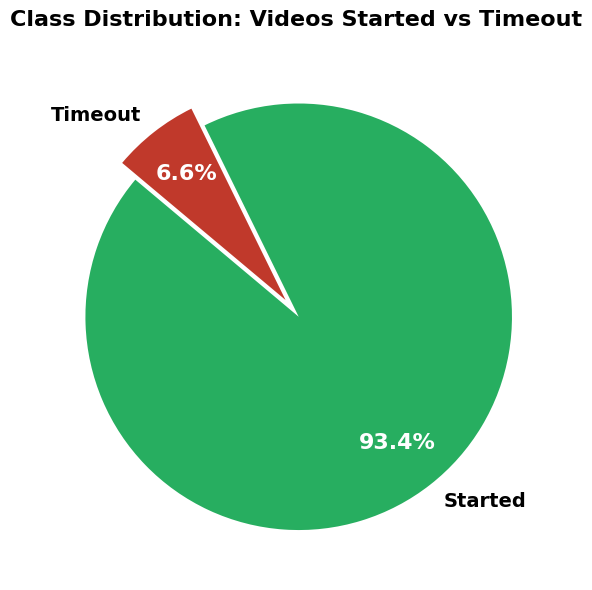


Class distribution:
Started: 104,518 (93.39%)
Timeout: 7,401 (6.61%)


In [53]:
# Class Distribution - Pie Chart
fig, ax = plt.subplots(figsize=(7, 6))

class_counts = df['video_started'].value_counts()
labels = ['Started', 'Timeout']
colors = ['#27ae60', '#c0392b']  # Darker green and red
explode = (0.02, 0.08)  # Less explode for Started, more for Timeout

wedges, texts, autotexts = ax.pie(
    class_counts,
    labels=labels,
    autopct='%1.1f%%',
    startangle=140,  # Rotate so timeout slice is more visible
    colors=colors,
    explode=explode,
    textprops={'fontsize': 14, 'weight': 'bold'},
    pctdistance=0.75  # Move percentages closer to center
)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(16)
    autotext.set_weight('bold')

ax.set_title('Class Distribution: Videos Started vs Timeout', fontsize=16, weight='bold', pad=15)

plt.tight_layout()
plt.show()

print(f"\nClass distribution:")
print(f"Started: {class_counts[1]:,} ({class_counts[1]/len(df)*100:.2f}%)")
print(f"Timeout: {class_counts[0]:,} ({class_counts[0]/len(df)*100:.2f}%)")

In [17]:
def prepare_classification_data(
    df,
    feature_cols,
    target_col,
    test_size=0.2,
    random_state=42
):
    data = df[feature_cols + [target_col]].copy()

    data = data.dropna(subset=[target_col])

    X = data[feature_cols]
    y = data[target_col]

    X = X.fillna(X.median())

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        stratify=y,
        random_state=random_state
    )

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test

## Baseline Classification Model

We use a Random Forest classifier as a strong, non-linear baseline model.
Random Forests are well suited for this task because:
- They capture threshold-based behavior common in network failures
- They are robust to noise and feature scaling
- They provide interpretable feature importance estimates

Class imbalance is handled using balanced class weights.


In [18]:
X_train, X_test, y_train, y_test = prepare_classification_data(
    df,
    feature_cols=FEATURE_SETS["operator"],
    target_col="video_started"
)

rf_clf = RandomForestClassifier(
    n_estimators=50,
    max_depth=15,
    min_samples_leaf=20,
    class_weight="balanced",
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf_clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=15,
                       min_samples_leaf=20, n_estimators=50, n_jobs=-1,
                       random_state=42)

In [19]:
y_pred = rf_clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=["timeout", "started"]))

              precision    recall  f1-score   support

     timeout       0.89      0.98      0.94      1480
     started       1.00      0.99      1.00     20904

    accuracy                           0.99     22384
   macro avg       0.95      0.99      0.97     22384
weighted avg       0.99      0.99      0.99     22384



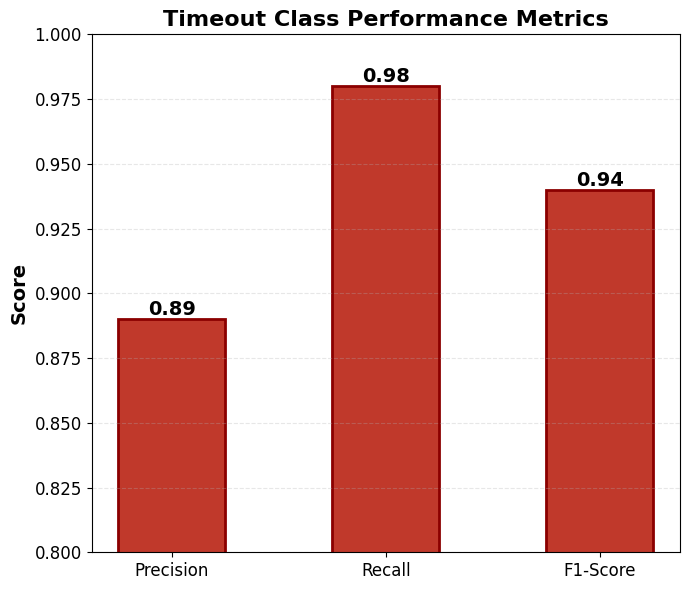

In [60]:
# Performance Metrics for Timeout Class
metrics = ['Precision', 'Recall', 'F1-Score']
values = [0.89, 0.98, 0.94]

fig, ax = plt.subplots(figsize=(7, 6))

bars = ax.bar(metrics, values, color='#c0392b', edgecolor='darkred', linewidth=2, width=0.5)

# Add value labels on top of bars
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{value:.2f}',
            ha='center', va='bottom', fontsize=14, weight='bold')

ax.set_ylabel('Score', fontsize=14, weight='bold')
ax.set_title('Timeout Class Performance Metrics', fontsize=16, weight='bold')
ax.set_ylim(0.8, 1.0)  # Start y-axis at 0.8 instead of 0
ax.tick_params(labelsize=12)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

## Baseline Performance Analysis

The confusion matrix and classification report show that startup failures (timeouts) are detected with high precision and recall.

This indicates that startup failure events correspond to distinct network conditions rather than subtle variations, making them well suited for classification.
Errors primarily occur in borderline cases where startup delay is close to the timeout threshold.


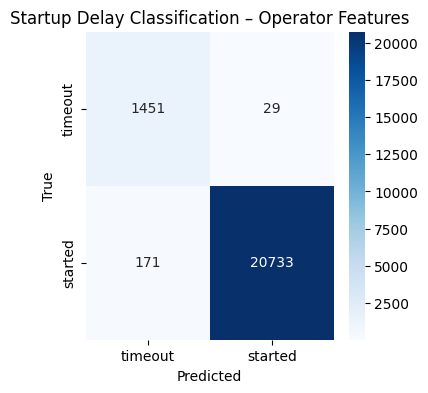

In [20]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["timeout", "started"],
            yticklabels=["timeout", "started"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Startup Delay Classification – Operator Features")
plt.show()

## Impact of Feature Visibility on Timeout Detection

We now evaluate how startup failure detection performance varies depending on the available feature set.
For each visibility scenario, we train the same classifier with identical hyperparameters to ensure a fair comparison.

In [21]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_results = []

for name, features in FEATURE_SETS.items():
    X = df[features].fillna(df[features].median())
    y = df["video_started"]

    fold_f1_timeout = []

    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)

        model = RandomForestClassifier(
            n_estimators=50,
            max_depth=15,
            min_samples_leaf=20,
            class_weight="balanced",
            random_state=RANDOM_STATE,
            n_jobs=-1
        )

        model.fit(X_train, y_train)
        y_val_pred = model.predict(X_val)

        fold_f1_timeout.append(
            f1_score(y_val, y_val_pred, pos_label=0)
        )

    cv_results.append({
        "feature_set": name,
        "f1_timeout_mean": np.mean(fold_f1_timeout),
        "f1_timeout_std": np.std(fold_f1_timeout)
    })

## Interpretation of Feature Visibility Results

The results show a clear performance hierarchy:
- Minimal features provide a baseline level of detection
- Operator-level packet statistics significantly improve timeout detection
- Full feature visibility yields the highest F1-score for the timeout class

This confirms that encrypted traffic statistics contain sufficient information to detect startup failures, even without access to application-layer data.

In [22]:
cv_df = pd.DataFrame(cv_results)
cv_df

,feature_set,f1_timeout_mean,f1_timeout_std
0,minimal,0.785927,0.005626
1,operator,0.928726,0.002470
2,full,1.000000,0.000000


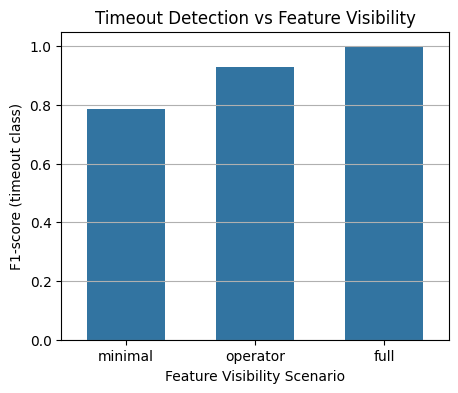

In [65]:
plt.figure(figsize=(5,4))
sns.barplot(
    data=cv_df,
    x="feature_set",
    y="f1_timeout_mean",
    width=0.6
)

plt.ylabel("F1-score (timeout class)")
plt.xlabel("Feature Visibility Scenario")
plt.title("Timeout Detection vs Feature Visibility")
plt.grid(axis="y")
plt.show()


In [24]:
rf_model = rf_clf

importances = rf_model.feature_importances_

feature_names = FEATURE_SETS["operator"]  # or "full"

fi_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)


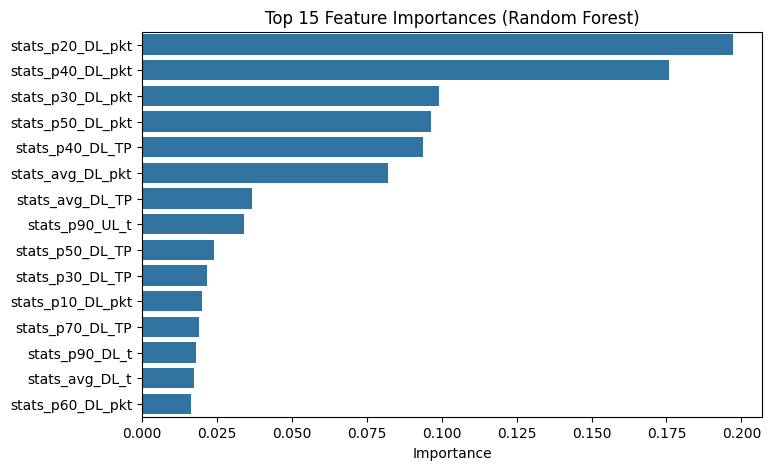

In [25]:
plt.figure(figsize=(8,5))
sns.barplot(
    data=fi_df.head(15),
    x="importance",
    y="feature"
)
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("")
plt.show()

In [26]:
perm = permutation_importance(
    rf_model,
    X_test,
    y_test,
    n_repeats=5,
    random_state=RANDOM_STATE,
    scoring="neg_root_mean_squared_error"
)

In [27]:
perm_df = pd.DataFrame({
    "feature": feature_names,
    "importance": perm.importances_mean
}).sort_values("importance", ascending=False)

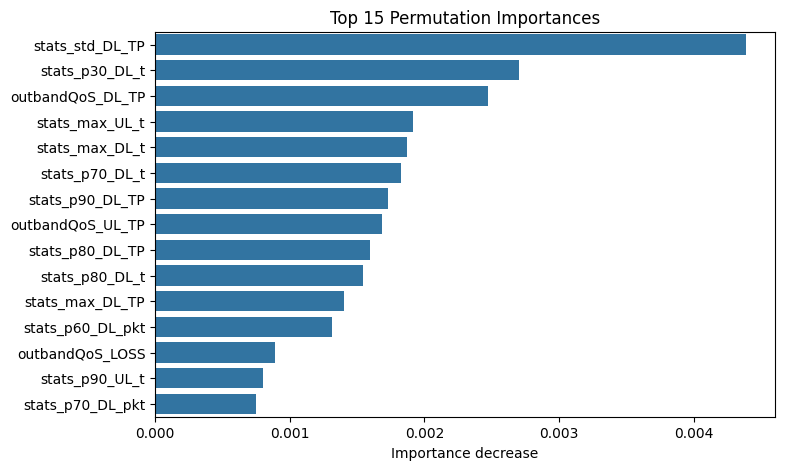

In [28]:
plt.figure(figsize=(8,5))
sns.barplot(
    data=perm_df.head(15),
    x="importance",
    y="feature"
)
plt.title("Top 15 Permutation Importances")
plt.xlabel("Importance decrease")
plt.ylabel("")
plt.show()

In [29]:
!pip install lifelines

## Explainability via Survival Analysis

While startup failure is treated as a binary classification problem, it naturally follows a **time-to-event process**:
- The event is video playback starting
- Sessions that do not start before the timeout are right-censored

We therefore complement the classifier with survival analysis to explain how startup risk evolves over time and how network conditions influence this process.


In [30]:
from lifelines import KaplanMeierFitter, CoxPHFitter

In [31]:
df_surv = df.copy()

# Duration until event or censoring
df_surv["duration"] = df_surv["startup_delay_sec"]

# Event observed: 1 = started, 0 = timeout
df_surv["event"] = (df_surv["startup_delay_sec"] < 30).astype(int)

df_surv[["duration", "event"]].head()


,duration,event
0,0.3411,1
1,0.2883,1
2,0.4803,1
3,31.0000,0
4,31.0000,0


In [32]:
kmf = KaplanMeierFitter()

kmf.fit(
    durations=df_surv["duration"],
    event_observed=df_surv["event"],
    label="Startup not yet occurred"
)

<lifelines.KaplanMeierFitter:"Startup not yet occurred", fitted with 111919 total observations, 7401 right-censored observations>

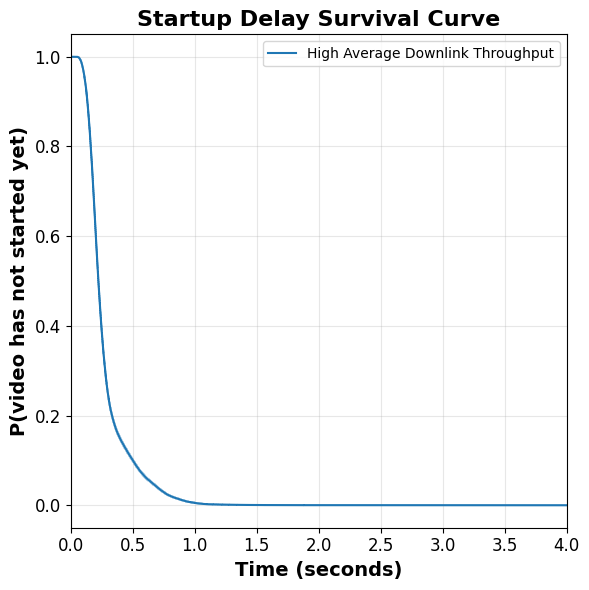

In [44]:
plt.figure(figsize=(6, 6))
kmf.plot_survival_function()
plt.xlabel("Time (seconds)", fontsize=14, weight='bold')
plt.ylabel("P(video has not started yet)", fontsize=14, weight='bold')
plt.title("Startup Delay Survival Curve", fontsize=16, weight='bold')
plt.xlim(0, 4)  # Limit x-axis to 15 seconds
plt.grid(True, alpha=0.3)
plt.tick_params(labelsize=12)
plt.tight_layout()
plt.show()

In [34]:
median_rtt = df_surv["outbandQoS_RTT"].median()

df_surv["RTT_group"] = np.where(
    df_surv["outbandQoS_RTT"] > median_rtt,
    "High RTT",
    "Low RTT"
)

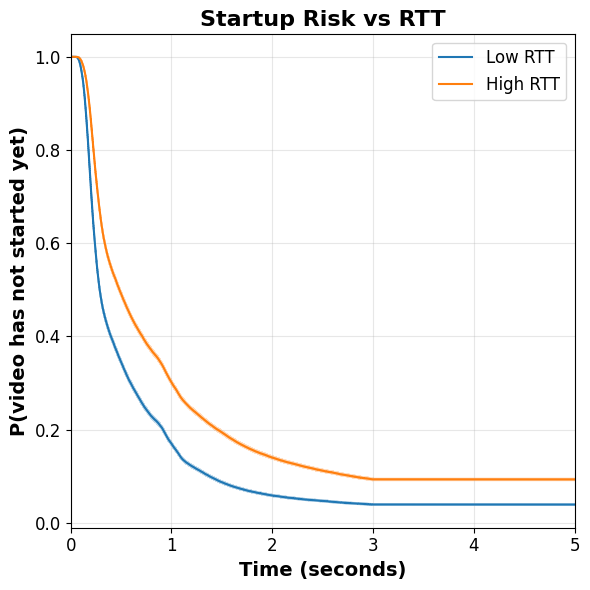

In [46]:
plt.figure(figsize=(6, 6))

for group in ["Low RTT", "High RTT"]:
    mask = df_surv["RTT_group"] == group
    kmf.fit(
        df_surv.loc[mask, "duration"],
        df_surv.loc[mask, "event"],
        label=group
    )
    kmf.plot_survival_function()

plt.xlabel("Time (seconds)", fontsize=14, weight='bold')
plt.ylabel("P(video has not started yet)", fontsize=14, weight='bold')
plt.title("Startup Risk vs RTT", fontsize=16, weight='bold')
plt.xlim(0, 5)  # Limit x-axis to 15 seconds
plt.grid(True, alpha=0.3)
plt.tick_params(labelsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


In [37]:
median_avg_DL_TP = df_surv["stats_avg_DL_TP"].median()

df_surv["stats_avg_DL_TP_group"] = np.where(
    df_surv["stats_avg_DL_TP"] > median_avg_DL_TP,
    "High Average Downlink Throughput",
    "Low Average Downlink Throughput"
)

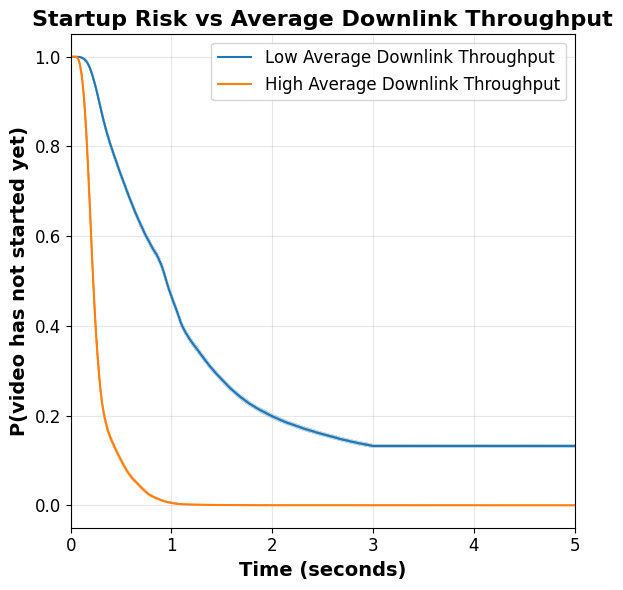

In [48]:
plt.figure(figsize=(6, 6))

for group in ["Low Average Downlink Throughput", "High Average Downlink Throughput"]:
    mask = df_surv["stats_avg_DL_TP_group"] == group
    kmf.fit(
        df_surv.loc[mask, "duration"],
        df_surv.loc[mask, "event"],
        label=group
    )
    kmf.plot_survival_function()

plt.xlabel("Time (seconds)", fontsize=14, weight='bold')
plt.ylabel("P(video has not started yet)", fontsize=14, weight='bold')
plt.title("Startup Risk vs Average Downlink Throughput", fontsize=16, weight='bold')
plt.xlim(0, 5)  # Limit x-axis to 15 seconds
plt.grid(True, alpha=0.3)
plt.tick_params(labelsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

## Interpretation of Startup Risk Stratified by Network Conditions

The stratified Kaplan–Meier curves provide a time-resolved view of startup risk under different network conditions.

**Effect of Downlink Throughput:**  
Sessions with high average downlink throughput experience a very rapid drop in startup risk, with most videos starting within the first few seconds. In contrast, low-throughput sessions retain a non-negligible probability of not having started even several seconds into playback, indicating a higher risk of timeout.

**Effect of RTT:**  
High-RTT sessions consistently exhibit a higher probability of not having started at any given time compared to low-RTT sessions. This gap appears early and persists until the timeout threshold, highlighting latency as a dominant factor in startup delay.

These curves reveal that startup failures are not random late events but are instead driven by early network conditions. This temporal separation explains why startup failure detection is highly accurate using network-level features and supports the classifier’s strong performance.



In [39]:
cox_features = [
    "outbandQoS_RTT",
    "outbandQoS_DL_TP",
    "outbandQoS_LOSS"
]

df_cox = df_surv[cox_features + ["duration", "event"]].dropna()

In [40]:
cph = CoxPHFitter()
cph.fit(df_cox, duration_col="duration", event_col="event")
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 111919 total observations, 7401 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 111919
number of events observed = 104518
   partial log-likelihood = -1091703.46
         time fit was run = 2026-02-09 20:03:07 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
outbandQoS_RTT   -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
outbandQoS_DL_TP  0.00      1.00      0.00            0.00            0.00                1.00                1.00
outbandQoS_LOSS  -4.63      0.01      0.14           -4.90           -4.36                0.01                0.01

                  cmp to      z      p  -log2(p)
covariate                                       
outbandQoS_RTT      0.00 -66.82 <0.005       inf
outbandQoS_DL_TP    0.00 297.89 <0.005       inf
outbandQoS_LOSS     0.00 -33.64 <0.005    821.58
---
Concordance = 0.81
Partial AIC = 2183412.91
log-likelihood ratio test = 77918.84 on 3 df
-log2(p) of ll-ratio test = inf

### Interpretation of the Cox Proportional Hazards Model

We model the **startup process as a time-to-event problem**, where the event corresponds to the video successfully starting, and sessions that reach the 30s limit are treated as censored (timeouts). The Cox Proportional Hazards model estimates the *instantaneous risk that the video has not started yet* as a function of network conditions.

#### Feature-level effects (Hazard Ratios)

- **Packet loss (`outbandQoS_LOSS`)** emerges as the dominant factor influencing startup success.  
  The estimated hazard ratio is approximately **0.01**, meaning that even moderate increases in loss drastically reduce the probability of the video starting within a given time window. This aligns with networking intuition: loss severely impacts TCP/QUIC behavior during the initial buffering phase.

- **Downlink throughput (`outbandQoS_DL_TP`)** has a statistically significant effect, although its coefficient appears numerically small due to the feature being expressed in bits per second. Over realistic throughput ranges, higher downlink capacity substantially accelerates startup.

- **Round-trip time (`outbandQoS_RTT`)** shows a comparatively weaker marginal effect once throughput and loss are accounted for. This suggests that latency alone is not the primary bottleneck for startup, but rather interacts indirectly through congestion and loss dynamics.

#### Model quality and validity

- The **concordance index of 0.81** indicates strong discriminative power: the model correctly orders pairs of sessions by startup time in over 80% of cases.
- The **log-likelihood ratio test is highly significant**, confirming that the selected network features jointly explain a substantial portion of startup variability.

Overall, the survival analysis complements the classification results by providing a **time-aware, interpretable view of startup risk**, highlighting packet loss as the most critical factor governing whether and how fast a video can start.

